### Instructor Demo: Stock Price Simulation

This program executes a single simulation of stock price trajectory over the next `252` trading days (or year of trading) for `AAPL` stock, based on a normal probability distribution of historical average daily returns derived from the sample mean and standard deviation.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'ARCA',
     'id': '02b6820c-e5d5-462f-b3d0-d600919dffd7',
     'marginable': True,
     'name': 'Direxion Daily Gold Miners Bull 3X Shares of Direxion Shares ETF '
             'Trust',
     'shortable': False,
     'status': 'active',
     'symbol': 'NUGT',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': 'd174dc71-0a75-47a7-a43c-5cf9360111bf',
     'marginable': True,
     'name': 'ETF Series Solutions Trust Loncar Cancer Immunotherapy ETF',
     'shortable': False,
     'status': 'active',
     'symbol': 'CNCR',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': '07844fc5-d49c-41dd-a543-dccaf6aec65c',
     'marginable': True,
     'name': 'Co-Diagnostics, Inc. Common Stock',
     'shortable': False,
     'status': 'active',
     'symbol': 'CODX',
     't

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,NUGT
1,CNCR
2,CODX
3,TDOC
4,ONEM
5,CRAI
6,SPWH
7,MEXX_deprecated
8,SDPI
9,KREF


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [5]:
# Set the ticker
ticker = "AAPL"

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

AAPL                                    
                             open     high      low   close    volume
2019-11-04 00:00:00-05:00  257.33  257.845  255.380  257.48  23618001
2019-11-05 00:00:00-05:00  257.05  258.190  256.320  257.15  17738372
2019-11-06 00:00:00-05:00  256.84  257.490  255.365  257.24  15328064
2019-11-07 00:00:00-05:00  258.74  260.350  258.110  259.50  22267200
2019-11-08 00:00:00-05:00  258.69  260.440  256.850  260.14  15896858

### Drop Extraneous Levels and Columns

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.head()

,close
2019-11-04,257.48
2019-11-05,257.15
2019-11-06,257.24
2019-11-07,259.50
2019-11-08,260.14


### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of AAPL
daily_returns = df.pct_change()
daily_returns.head()

,close
2019-11-04,NaN
2019-11-05,-0.001282
2019-11-06,0.000350
2019-11-07,0.008786
2019-11-08,0.002466


### Calculate Value of Average Daily Returns

In [8]:
# Use the `mean` function to calculate the mean of daily returns for AAPL
avg_daily_return = daily_returns.mean()['close']
avg_daily_return

0.00017627329176443535

### Calculate Value of Standard Deviation of Daily Returns

In [9]:
# Use the `std` function to calculate the standard deviation of daily returns for AAPL
std_dev_daily_return = daily_returns.std()['close']
std_dev_daily_return

0.0338537158765597

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [10]:
# Set number of trading days and get last closing price of AAPL from DataFrame
num_trading_days = 252
aapl_last_price = df['close'][-1]

# Initialize the simulated prices list with the last closing price of AAPL
simulated_aapl_prices = [aapl_last_price]

# Simulate the returns for 252 days
for i in range(num_trading_days):
    # Calculate the simulated price using the last price within the list
    simulated_price = simulated_aapl_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
    # Append the simulated price to the list
    simulated_aapl_prices.append(simulated_price)
    
# Create a DataFrame of the simulated prices
simulated_price_df = pd.DataFrame({
    "Simulated AAPL Prices": simulated_aapl_prices
})

# Print head of DataFrame
simulated_price_df.head()

,Simulated AAPL Prices
0,247.620000
1,237.788771
2,234.963922
3,243.619485
4,258.901836


### Plot the Simulated Stock Price Trajectory for AAPL over the Next Year (252 Trading Days)

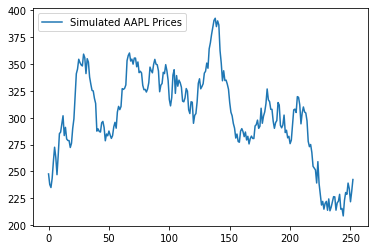

In [11]:
# Use the `plot` function to plot the trajectory of AAPL stock based on a 252 trading day simulation
simulated_price_df.plot()

### Calculate Daily Returns of Simulated Stock Prices for AAPL

In [12]:
# Use the `pct_change` function to calculate daily returns of simulated stock prices for AAPL
simulated_daily_returns = simulated_price_df.pct_change()
simulated_daily_returns.head()

,Simulated AAPL Prices
0,NaN
1,-0.039703
2,-0.011880
3,0.036838
4,0.062730


### Calculate the Cumulative Returns of Simulated Stock Prices for AAPL

In [13]:
# Use the `cumprod` function to calculate the cumulative returns of simulated stock prices for AAPL
simulated_cumulative_returns = (1 + simulated_daily_returns).cumprod()
simulated_cumulative_returns.head()

,Simulated AAPL Prices
0,NaN
1,0.960297
2,0.948889
3,0.983844
4,1.045561


### Calculate the Cumulative Profits/Losses of Simulated Stock Prices for AAPL

In [14]:
# Multiply an initial investment by the cumulative returns of simulative stock prices to
# return the progression of cumulative returns in terms of money
initial_investment = 10000
cumulative_pnl = initial_investment * simulated_cumulative_returns
cumulative_pnl.head()

,Simulated AAPL Prices
0,NaN
1,9602.971133
2,9488.891124
3,9838.441358
4,10455.610836


### Plot the Cumulative Profits/Losses of `$10,000` in AAPL Over the Next `252` Trading Days

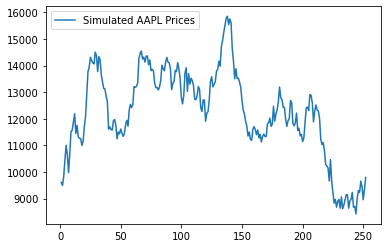

In [15]:
# Use the 'plot' function to create a chart of the cumulative profits/losses
cumulative_pnl.plot()